# Cell 1 — Clean install & GPU check (Colab-safe)

In [ ]:
# !nvidia-smi -L || print("⚠️ No GPU detected. Go to Runtime > Change runtime type > GPU.")
!nvidia-smi -L
# Remove RAPIDS if present (they pin old pyarrow)
!pip -q uninstall -y cudf-cu12 dask-cudf-cu12 cuml-cu12 pylibcudf-cu12 rmm-cu12 ucx-py ucxx rapids-dask-dependency || true
# Colab-friendly versions
!pip -q install -U pandas==2.2.2 pyarrow==21.0.0
!pip -q install -U transformers datasets accelerate scikit-learn


GPU 0: Tesla T4 (UUID: GPU-0277f83b-4ecc-2b8e-1778-611e3432ed3e)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 37.3 MB/s eta 0:00:00


# Cell 2 — (Optional) Mount Drive

In [ ]:
from google.colab import drive
USE_DRIVE = False  # set False if you don’t want Drive
if USE_DRIVE:
    SAVE_DIR = "/content/drive/MyDrive/baitbuster_two_stage"
else:
    SAVE_DIR = "/content/baitbuster_two_stage"

import os
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)

Saving to: /content/baitbuster_two_stage


# Cell 3 — Load dataset

In [ ]:
import pandas as pd, os

CSV_PATH     = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.csv"
PARQUET_PATH = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.parquet"
XLSX_PATH    = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.xlsx"

if   os.path.exists(CSV_PATH):     df_all = pd.read_csv(CSV_PATH)
elif os.path.exists(PARQUET_PATH): df_all = pd.read_parquet(PARQUET_PATH)
elif os.path.exists(XLSX_PATH):    df_all = pd.read_excel(XLSX_PATH)
else: raise FileNotFoundError("Upload dataset and update the paths.")

print("Columns:", list(df_all.columns)[:30])
print("Rows:", len(df_all))

Columns: ['channel_id', 'channel_name', 'channel_url', 'video_id', 'publishedAt', 'title', 'title_debiased', 'description', 'description_debiased', 'url', 'viewCount', 'commentCount', 'likeCount', 'dislikeCount', 'thumbnail', 'auto_labeled', 'human_labeled', 'ai_labeled']
Rows: 253070


# Cell 4 — Preprocess: normalize labels & texts; build label source


In [ ]:
import numpy as np
import pandas as pd

TITLE_COL = "title_debiased" if "title_debiased" in df_all.columns else "title"
assert TITLE_COL in df_all.columns, f"Missing {TITLE_COL}"

# (Optional) If you later want dual-input, set DESC_COL here and keep it cleaned too.
# DESC_COL  = "description_debiased" if "description_debiased" in df_all.columns else "description"

def norm_label(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    mapping = {
        "not_clickbait":"not clickbait", "non-clickbait":"not clickbait",
        "non_clickbait":"not clickbait", "notclickbait":"not clickbait",
        "click bait":"clickbait", "yes":"clickbait", "no":"not clickbait",
        "1":"clickbait", "0":"not clickbait"
    }
    return mapping.get(s, s if s in ["clickbait","not clickbait"] else None)

# Build best-available label and its source
def choose_label_and_source(row):
    for col, src in [("human_labeled","human"), ("ai_labeled","ai"), ("auto_labeled","auto")]:
        if col in row.index and pd.notna(row[col]):
            lab = norm_label(row[col])
            if lab in ["clickbait","not clickbait"]:
                return lab, src
    return None, None

labs, srcs = [], []
for _, r in df_all.iterrows():
    l, s = choose_label_and_source(r)
    labs.append(l); srcs.append(s)

df_all["label_str"] = labs
df_all["label_source"] = srcs
df_all = df_all[df_all["label_str"].isin(["clickbait","not clickbait"])].copy()
df_all["label"] = (df_all["label_str"] == "clickbait").astype(int)

# Clean text
df_all[TITLE_COL] = df_all[TITLE_COL].astype(str).str.strip()
df_all = df_all[df_all[TITLE_COL].ne("")].copy()

print("Total usable rows (any label):", len(df_all))
print("Label balance 0/1:", np.bincount(df_all["label"]))
print(df_all["label_source"].value_counts(dropna=False).to_frame("count"))
df_all[[TITLE_COL,"label_str","label_source"]].head()

Total usable rows (any label): 253070
Label balance 0/1: [208024  45046]
               count
label_source        
ai            243070
human          10000


,title_debiased,label_str,label_source
0,এইমাত্র! মসজিদে নামাজরত অবস্থায় তিন বৃদ্ধকে পি...,clickbait,human
1,"১০ বছরের সন্তান ফেলে আ,লীগ নেতার সাথে পালিয়ে গ...",clickbait,human
2,এই মাত্র পাওয়া খবর! ৫ বছরের জেল হচ্ছে পরীমনির!...,clickbait,human
3,ছি ছি! ভাগিনার সাথে পরকীয়ার সময় হাতেনাতে ধরা খ...,clickbait,human
4,হায়রে পরীমনি! কারাগারে গিয়েও ভালো হলোনা! কারাগ...,clickbait,human


/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 2468 (\N{BENGALI LETTER TA}) missing from font(s) D

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('title_debiased').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Cell 5 — Make human-only splits, then define Stage-1 and Stage-2 pools

In [ ]:
from sklearn.model_selection import train_test_split

# 1) Take human-only rows
is_human = (df_all["label_source"] == "human")
df_human = df_all[is_human].copy()

# Human split 70/15/15
idx = np.arange(len(df_human))
h_tr_idx, h_tmp = train_test_split(idx, test_size=0.30, stratify=df_human["label"].values, random_state=42)
h_va_idx, h_te_idx = train_test_split(h_tmp, test_size=0.50, stratify=df_human["label"].values[h_tmp], random_state=42)

df_h_tr = df_human.iloc[h_tr_idx].copy()
df_h_va = df_human.iloc[h_va_idx].copy()
df_h_te = df_human.iloc[h_te_idx].copy()

print("Human splits sizes:", len(df_h_tr), len(df_h_va), len(df_h_te))

# 2) Build a mask to exclude human val/test from Stage-1
human_valtest_ids = set(df_h_va.index.tolist() + df_h_te.index.tolist())
mask_stage1 = ~df_all.index.isin(human_valtest_ids)

df_stage1 = df_all[mask_stage1].copy()     # Stage-1 train pool (human-train + AI + auto)
df_stage2 = df_h_tr.copy()                  # Stage-2 train = human-train
df_eval_val = df_h_va.copy()                # Validation on human-val
df_eval_test = df_h_te.copy()               # Final test on human-test

# 3) Optional sample weights by label source for Stage-1
weight_map = {"human": 1.0, "ai": 0.7, "auto": 0.5}
df_stage1["sample_weight"] = df_stage1["label_source"].map(weight_map).fillna(0.5)

print("\nStage-1 size:", len(df_stage1), " (by source)")
print(df_stage1["label_source"].value_counts())
print("\nStage-2 (human-train) size:", len(df_stage2))
print("\nEval val/test sizes:", len(df_eval_val), len(df_eval_test))

Human splits sizes: 7000 1500 1500

Stage-1 size: 250070  (by source)
label_source
ai       243070
human      7000
Name: count, dtype: int64

Stage-2 (human-train) size: 7000

Eval val/test sizes: 1500 1500


# Cell 6 — Tokenize (BanglaBERT) and build HF datasets

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

MODEL_NAME = "csebuetnlp/banglabert"  # or "sagorsarker/bangla-bert-base"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
MAX_LEN = 96

def map_simple(df, include_weights=False):
    enc = tok(df[TITLE_COL].tolist(), truncation=True, padding="max_length", max_length=MAX_LEN)
    data = {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": df["label"].astype(int).tolist(),
    }
    if include_weights:
        data["sample_weight"] = df["sample_weight"].astype("float32").tolist()
    return Dataset.from_dict(data)

ds_stage1 = map_simple(df_stage1, include_weights=True)   # has sample_weight
ds_stage2 = map_simple(df_stage2, include_weights=False)
ds_val    = map_simple(df_eval_val, include_weights=False)
ds_test   = map_simple(df_eval_test, include_weights=False)

for d in [ds_stage1, ds_stage2, ds_val, ds_test]:
    d.set_format(type="torch")

len(ds_stage1), len(ds_stage2), len(ds_val), len(ds_test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

(250070, 7000, 1500, 1500)

# Cell 7 — Define model, metrics, and a Trainer with optional weighted loss

In [ ]:
import torch, torch.nn as nn
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_micro": f1_score(labels, preds, average="micro"),
        "kappa":    cohen_kappa_score(labels, preds),
    }

class WeightedTrainer(Trainer):
    # accept extra kwargs for compatibility with new transformers
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # pull out labels/weights; leave the rest (input_ids, attention_mask, etc.)
        labels = inputs.pop("labels")
        weights = inputs.pop("sample_weight", None)  # present only for stage-1

        # forward pass
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

        # per-example CE
        ce = nn.CrossEntropyLoss(reduction="none")(logits, labels)

        # weighted reduction if weights provided
        if weights is not None:
            # ensure device/shape
            weights = weights.to(ce.device).view(-1)
            loss = (ce * weights).sum() / (weights.sum() + 1e-8)
        else:
            loss = ce.mean()

        return (loss, outputs) if return_outputs else loss

# Cell 8 — Stage-1 pretraining (all labels except human-val/test)

In [ ]:
stage1_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# try new/old arg names for evaluation_strategy
try:
    stage1_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage1_all"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=2,          # 2–3 is usually enough for pretraining
        weight_decay=0.01,
        evaluation_strategy="no",    # no eval in stage-1; we’ll eval after stage-2
        save_strategy="epoch",
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    stage1_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage1_all"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="no",
        save_strategy="epoch",
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

stage1_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
stage1_trainer = WeightedTrainer(
    model=stage1_model,
    args=stage1_args,
    train_dataset=ds_stage1,
)
stage1_trainer.train()
stage1_ckpt = os.path.join(SAVE_DIR, "stage1_all_best")
stage1_trainer.save_model(stage1_ckpt)
print("Stage-1 checkpoint saved to:", stage1_ckpt)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.368300
200,0.266600
300,0.241900
400,0.235000
500,0.224000
600,0.203000
700,0.193600
800,0.197200
900,0.175900
1000,0.190000


Stage-1 checkpoint saved to: /content/baitbuster_two_stage/stage1_all_best


# Cell 9 — Stage-2 fine-tune on human-train, validate on human-val (early stop)

In [ ]:
from transformers import EarlyStoppingCallback

stage2_model = AutoModelForSequenceClassification.from_pretrained(stage1_ckpt, num_labels=2)

try:
    stage2_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage2_human"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=4,                 # 3–5 typically good
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    stage2_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "stage2_human"),
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=4,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=100,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

stage2_trainer = Trainer(
    model=stage2_model,
    args=stage2_args,
    train_dataset=ds_stage2,   # human-train only
    eval_dataset=ds_val,       # human-val
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

stage2_trainer.train()
stage2_ckpt = os.path.join(SAVE_DIR, "stage2_human_best")
stage2_trainer.save_model(stage2_ckpt)
print("Stage-2 best checkpoint saved to:", stage2_ckpt)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,Kappa
1,0.033000,0.030928,0.990667,0.990501,0.990667,0.981002
2,0.009400,0.030610,0.993333,0.993215,0.993333,0.986430
3,0.004500,0.032135,0.993333,0.993213,0.993333,0.986426
4,0.001200,0.034955,0.994000,0.993895,0.994000,0.987789


Stage-2 best checkpoint saved to: /content/baitbuster_two_stage/stage2_human_best


# Cell 10 — Final evaluation on human-test (never seen in Stage-2)

In [ ]:
raw_val  = stage2_trainer.predict(ds_val)
raw_test = stage2_trainer.predict(ds_test)

from pprint import pprint
print("=== HUMAN-VAL METRICS ===")
pprint({
    "accuracy": (raw_val.predictions.argmax(axis=1) == raw_val.label_ids).mean().item(),
    **compute_metrics((raw_val.predictions, raw_val.label_ids))
})

print("\n=== HUMAN-TEST METRICS ===")
test_metrics = compute_metrics((raw_test.predictions, raw_test.label_ids))
pprint(test_metrics)

# Confusion matrix on test
from sklearn.metrics import confusion_matrix, classification_report
y_pred = raw_test.predictions.argmax(axis=1)
print("\nConfusion matrix [rows=true, cols=pred] (0,1):\n", confusion_matrix(raw_test.label_ids, y_pred))
print("\nClassification report:\n", classification_report(raw_test.label_ids, y_pred, digits=4))

# Save
import pandas as pd, json, os
pd.DataFrame([test_metrics]).to_csv(os.path.join(SAVE_DIR, "final_human_test_metrics.csv"), index=False)
with open(os.path.join(SAVE_DIR, "final_human_test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)

=== HUMAN-VAL METRICS ===
{'accuracy': 0.994,
 'f1_macro': 0.9938946929505411,
 'f1_micro': 0.994,
 'kappa': 0.9877894356005789}

=== HUMAN-TEST METRICS ===
{'accuracy': 0.9933333333333333,
 'f1_macro': 0.9932199222189477,
 'f1_micro': 0.9933333333333333,
 'kappa': 0.9864398689548936}

Confusion matrix [rows=true, cols=pred] (0,1):
 [[648   6]
 [  4 842]]

Classification report:
               precision    recall  f1-score   support

           0     0.9939    0.9908    0.9923       654
           1     0.9929    0.9953    0.9941       846

    accuracy                         0.9933      1500
   macro avg     0.9934    0.9930    0.9932      1500
weighted avg     0.9933    0.9933    0.9933      1500



# **Cell 11** - Visualizing Results

/tmp/ipython-input-4215517758.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=ax, palette="Blues_d")


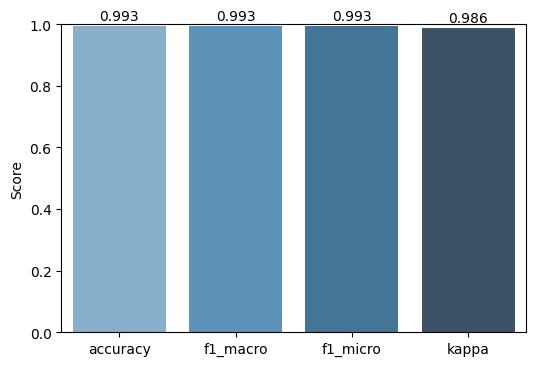

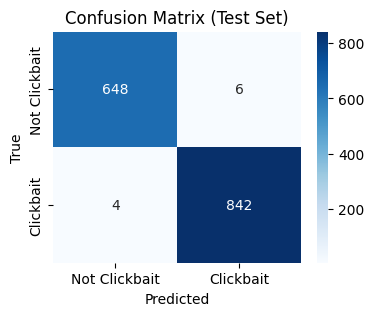

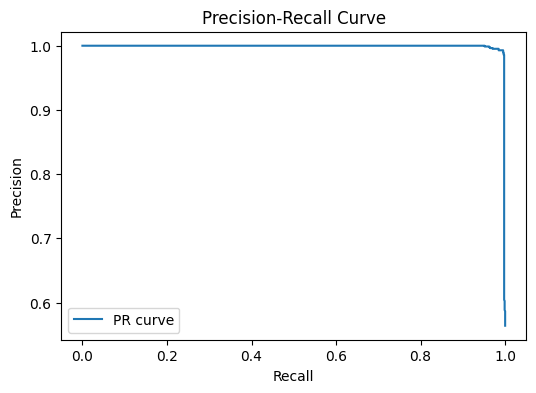

In [ ]:
# Cell 11 — Visualize results

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Plot metrics
metrics = test_metrics  # from Cell 10
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=ax, palette="Blues_d")
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
# ax.set_title("Final Test Metrics")
for i, v in enumerate(metrics.values()):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center")
plt.show()

# 2) Confusion matrix heatmap
cm = confusion_matrix(raw_test.label_ids, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Clickbait","Clickbait"],
            yticklabels=["Not Clickbait","Clickbait"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# 3) Optional: Precision vs Recall curve (top-10 predictions vs threshold)
from sklearn.metrics import precision_recall_curve

probs = torch.nn.functional.softmax(torch.tensor(raw_test.predictions), dim=1)[:,1].numpy()
prec, rec, thres = precision_recall_curve(raw_test.label_ids, probs)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


=== TRAIN (human 70%) split ===


,count,percent
label,,
0,3049,43.56
1,3951,56.44



=== VAL (human 15%) split ===


,count,percent
label,,
0,653,43.53
1,847,56.47



=== TEST (human 15%) split ===


,count,percent
label,,
0,654,43.6
1,846,56.4


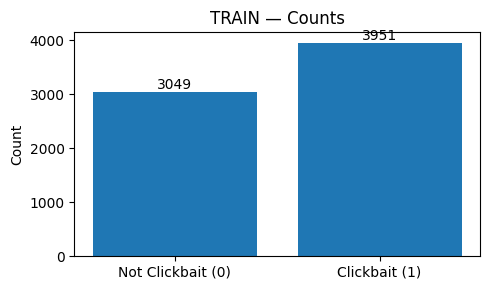

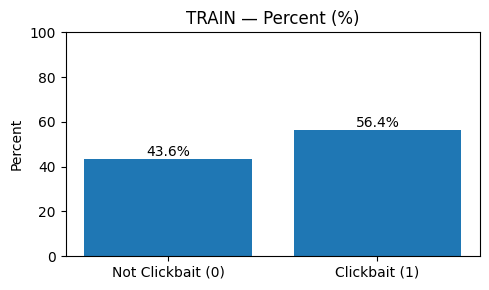

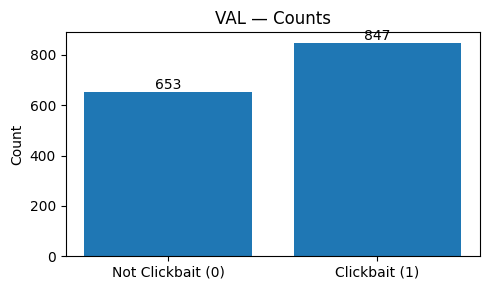

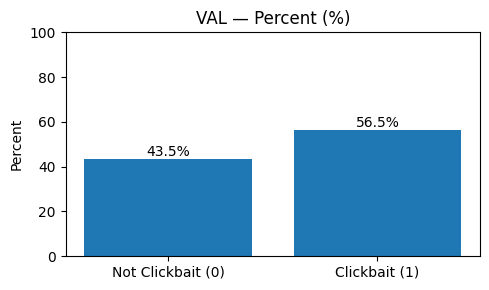

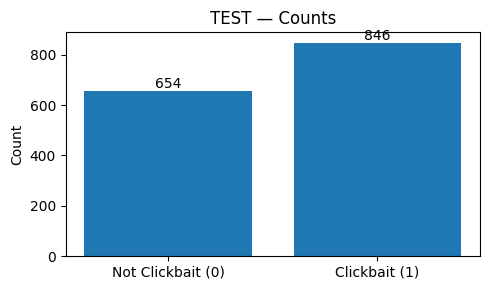

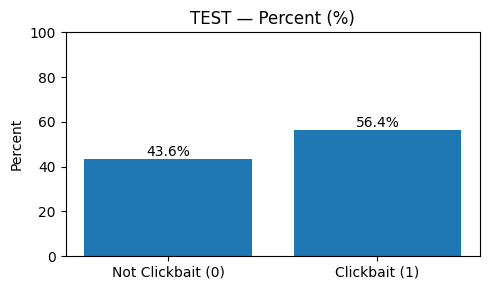


Estimated class % (0,1) by split:
TRAIN: {0: 43.56, 1: 56.44}
VAL  : {0: 43.53, 1: 56.47}
TEST : {0: 43.6, 1: 56.4}


In [ ]:
# Cell 11 — Check class distribution per split (train/val/test)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_split(name, df):
    counts = df["label"].value_counts().reindex([0,1], fill_value=0)
    total = counts.sum()
    pct = (counts / total * 100).round(2)
    summary = pd.DataFrame({
        "count": counts.astype(int),
        "percent": pct
    })
    print(f"\n=== {name} split ===")
    display(summary)
    return summary

# Safety checks (these were defined in Cell 5)
for var_name in ["df_h_tr", "df_h_va", "df_h_te"]:
    assert var_name in globals(), f"{var_name} not found. Run Cell 5 first."

s_tr = summarize_split("TRAIN (human 70%)", df_h_tr)
s_va = summarize_split("VAL (human 15%)",   df_h_va)
s_te = summarize_split("TEST (human 15%)",  df_h_te)

# Helper to plot one chart per split
def plot_split_bar(title, summary_df):
    labels = ["Not Clickbait (0)", "Clickbait (1)"]
    x = np.arange(len(labels))

    # 1) Counts
    plt.figure(figsize=(5,3))
    plt.bar(x, summary_df["count"].reindex([0,1], fill_value=0).values)
    plt.xticks(x, labels, rotation=0)
    plt.ylabel("Count")
    plt.title(f"{title} — Counts")
    for i, v in enumerate(summary_df["count"].reindex([0,1], fill_value=0).values):
        plt.text(i, v, str(v), ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

    # 2) Percents
    plt.figure(figsize=(5,3))
    plt.bar(x, summary_df["percent"].reindex([0,1], fill_value=0).values)
    plt.xticks(x, labels, rotation=0)
    plt.ylabel("Percent")
    plt.ylim(0, 100)
    plt.title(f"{title} — Percent (%)")
    for i, v in enumerate(summary_df["percent"].reindex([0,1], fill_value=0).values):
        plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

plot_split_bar("TRAIN", s_tr)
plot_split_bar("VAL",   s_va)
plot_split_bar("TEST",  s_te)

# Quick sanity check that stratification held (differences <= ~1%)
def percent_of(df):
    vc = df["label"].value_counts(normalize=True).reindex([0,1], fill_value=0.0)
    return vc

p_tr, p_va, p_te = percent_of(df_h_tr), percent_of(df_h_va), percent_of(df_h_te)
print("\nEstimated class % (0,1) by split:")
print("TRAIN:", (p_tr*100).round(2).to_dict())
print("VAL  :", (p_va*100).round(2).to_dict())
print("TEST :", (p_te*100).round(2).to_dict())



=== FULL DATASET ===
Total rows: 253070
Label distribution (0=Not Clickbait, 1=Clickbait):


,count,percent
label,,
0,208024,82.2
1,45046,17.8


Label source breakdown:


,%
label_source,
ai,96.05
human,3.95



=== STAGE-1 TRAIN POOL ===
Total rows: 250070
Label distribution (0=Not Clickbait, 1=Clickbait):


,count,percent
label,,
0,206717,82.66
1,43353,17.34


Label source breakdown:


,%
label_source,
ai,97.2
human,2.8



=== STAGE-2 (HUMAN-TRAIN) ===
Total rows: 7000
Label distribution (0=Not Clickbait, 1=Clickbait):


,count,percent
label,,
0,3049,43.56
1,3951,56.44


Label source breakdown:


,%
label_source,
human,100.0


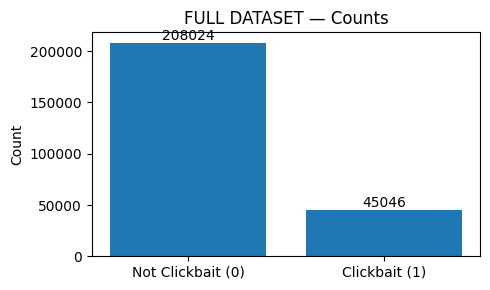

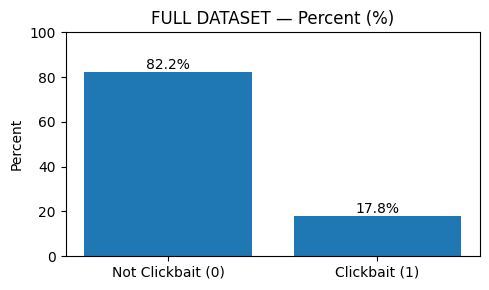

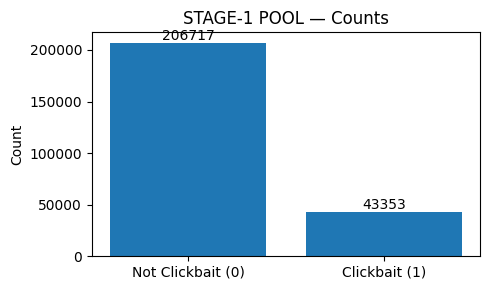

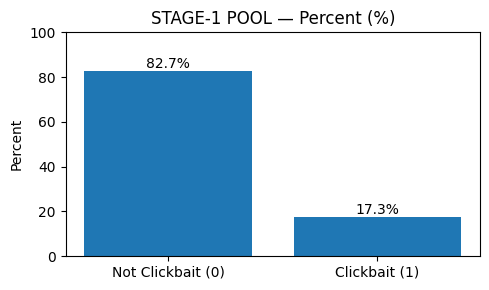

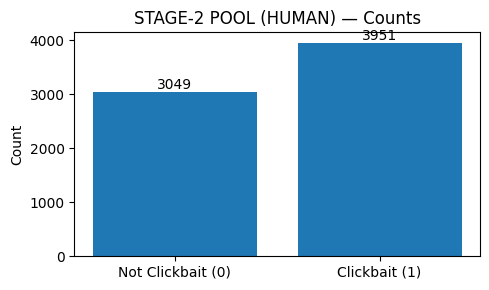

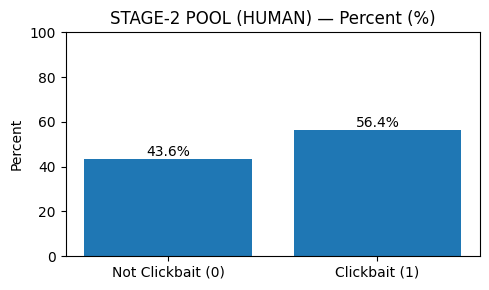

In [ ]:
# Cell 12 — Class & source distribution across full dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def summarize_dataset(name, df):
    counts = df["label"].value_counts().reindex([0,1], fill_value=0)
    total = counts.sum()
    pct = (counts / total * 100).round(2)
    print(f"\n=== {name} ===")
    print("Total rows:", total)
    print("Label distribution (0=Not Clickbait, 1=Clickbait):")
    display(pd.DataFrame({"count": counts, "percent": pct}))
    print("Label source breakdown:")
    display(df["label_source"].value_counts(normalize=True).mul(100).round(2).to_frame("%"))
    return counts, pct

# Run summaries
c_all, p_all = summarize_dataset("FULL DATASET", df_all)
c_s1, p_s1   = summarize_dataset("STAGE-1 TRAIN POOL", df_stage1)
c_s2, p_s2   = summarize_dataset("STAGE-2 (HUMAN-TRAIN)", df_stage2)

# Plot helper
def plot_bar(title, counts, pct):
    labels = ["Not Clickbait (0)", "Clickbait (1)"]
    x = np.arange(len(labels))

    plt.figure(figsize=(5,3))
    plt.bar(x, counts.reindex([0,1], fill_value=0).values)
    plt.xticks(x, labels, rotation=0)
    plt.ylabel("Count")
    plt.title(f"{title} — Counts")
    for i, v in enumerate(counts.reindex([0,1], fill_value=0).values):
        plt.text(i, v, str(v), ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5,3))
    plt.bar(x, pct.reindex([0,1], fill_value=0).values)
    plt.xticks(x, labels, rotation=0)
    plt.ylabel("Percent")
    plt.ylim(0,100)
    plt.title(f"{title} — Percent (%)")
    for i, v in enumerate(pct.reindex([0,1], fill_value=0).values):
        plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

# Draw plots
plot_bar("FULL DATASET", c_all, p_all)
plot_bar("STAGE-1 POOL", c_s1, p_s1)
plot_bar("STAGE-2 POOL (HUMAN)", c_s2, p_s2)


In [ ]:
print(df_all[TITLE_COL].duplicated().sum())

0
